In [ ]:
#@title **Downloading Dependencies**
%%capture
!pip install pennylane
!pip install hierarqcal
!pin install jax

!pip install numpy
!pip install tabulate

In [ ]:
#@title **Warning Filter**
import warnings
warnings.filterwarnings("ignore", message="PennyLane is currently not compatible with versions of JAX > 0.4.28. You have version 0.5.2 installed.")

In [ ]:
#@title **Loading the Data for the Electronic Hamiltonian ($HeH^+$ Molecule)**

import jax
from jax import numpy as np
import pennylane as qml
from tabulate import tabulate

"""JAX and NumPy are both Python libraries used for numerical computation, but they have key differences.

*   Immutability: JAX arrays are immutable, while NumPy arrays are mutable. This means that once a JAX array is created, it cannot be changed.
*   Autograd: JAX has built-in support for automatic differentiation, while NumPy does not.
*   JIT Compilation: JAX can use just-in-time (JIT) compilation to speed up code execution, while NumPy does not."""

jax.config.update("jax_platform_name", "cpu")
jax.config.update('jax_enable_x64', True)

# Load the data for HeH^+ molecule
dataset = qml.data.load('qchem', molname="HeH+")[0]

# Create the hamiltonian and determine the number of qubits we will need
H, qubits = dataset.hamiltonian, len(dataset.hamiltonian.wires)

print("Number of qubits:", qubits)
print("The Hamiltonian is given by:", H)

Number of qubits: 4
The Hamiltonian is given by: -1.5458724243288817 * I(0) + 0.7582840346680491 * Z(0) + 0.7582840346680491 * Z(1) + 0.23577187542980704 * (Z(0) @ Z(1)) + 0.05258434874916604 * (Y(0) @ Z(1) @ Y(2)) + 0.04324479694907271 * (Y(0) @ Y(2)) + 0.05258434874916604 * (X(0) @ Z(1) @ X(2)) + 0.04324479694907271 * (X(0) @ X(2)) + 0.05258434874916603 * (Y(1) @ Z(2) @ Y(3)) + 0.04324479694907271 * (Z(0) @ Y(1) @ Z(2) @ Y(3)) + 0.05258434874916603 * (X(1) @ Z(2) @ X(3)) + 0.04324479694907271 * (Z(0) @ X(1) @ Z(2) @ X(3)) + 0.03633593176600333 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.03633593176600333 * (Y(0) @ Y(1) @ X(2) @ X(3)) + -0.03633593176600333 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.03633593176600333 * (X(0) @ Y(1) @ Y(2) @ X(3)) + 0.191995644071161 * Z(2) + 0.1286780507371525 * (Z(0) @ Z(2)) + 0.191995644071161 * Z(3) + 0.16501398250315585 * (Z(0) @ Z(3)) + -0.009339551914671998 * (Y(0) @ Z(1) @ Y(2) @ Z(3)) + -0.009339551914671998 * (X(0) @ Z(1) @ X(2) @ Z(3)) + 0.16501398250315585 *

In [ ]:
#@title **Defining PennyLane's Lightning Qubit Simulator Device**

dev = qml.device("lightning.qubit", wires=qubits)

In [ ]:
#@title **Implementing Given's Rotation and Vector Representation of the Hartree-Fock State**
# Define number of electrons and the qubits for the Hartree-Fock state
electrons = 2
hf = qml.qchem.hf_state(electrons, qubits)

# Display the Hartree-Fock state
print("Hartree-Fock (HF) State:")
print(f"Number of electrons: {electrons}")
print(f"Number of qubits: {qubits}")
print(f"HF State Vector: {hf}")

Hartree-Fock (HF) State:
Number of electrons: 2
Number of qubits: 4
HF State Vector: [1 1 0 0]


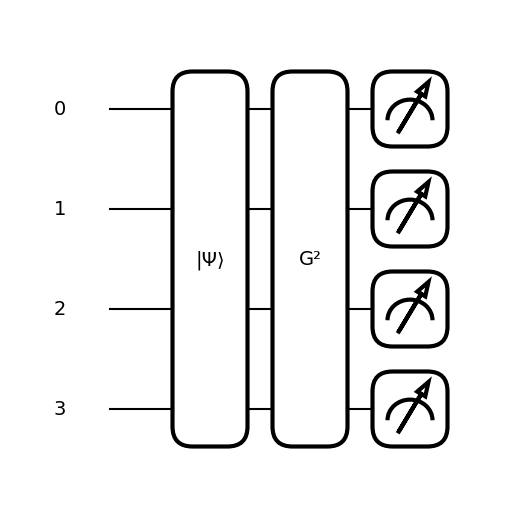

In [ ]:
#@title **Quantum Circuit Definition for Molecular Hamiltonian Expectation Calculation**

#@markdown - **DoubleExcitation(param, wires=[0, 1, 2, 3])**: This gate applies a two-particle excitation (or double excitation) to the qubits, where param is a parameter controlling the strength or magnitude of the excitation.
#@markdown - When **param = 0**, the DoubleExcitation gate will not alter the qubits at all, leaving them in their initial state.
#@markdown - When **param = 1**, it applies the full transformation, which might represent a certain angle of rotation or a specific quantum operation.

@qml.qnode(dev, interface="jax")
def circuit(param, wires):

    # initializes the 4-qubit register
    qml.BasisState(hf, wires=wires)
    qml.DoubleExcitation(param, wires=[0, 1, 2, 3])

    # return the expectation value of our molecular Hamiltonian prepared by the ciruit
    return qml.expval(H)

fig, ax = qml.draw_mpl(circuit)(param=0.5, wires=[0, 1, 2, 3])

In [ ]:
#@title **Energy Expectation Calculation for Given Quantum State**
# Initialise a quantum state and calculate the expectation value of the Hamiltonian H for that state
@qml.qnode(dev)
def exp_energy(state):
  qml.BasisState(np.array(state), wires=range(num_wires))
  return qml.expval(H)

num_wires = qubits
exp_energy(hf)
print("Qubits:", num_wires)
print("Energy Expectation:", exp_energy(hf))

Qubits: 4
Energy Expectation: -2.8419359554488315


In [ ]:
#@title **Ansatz Circuit for Candidate Ground State Preparation**
# build the circuit that prepares the candidate ground state
# params are the parameters of the DEG
def ansatz(params):
  # modify the hf-state, which acts on all the wires
  qml.BasisState(hf, wires=range(num_wires))

  # act with the 1st DEG, 1st element in the list params and acts on wires 0,1,2,3
  # --> since it takes the electons from the lowest energy level to the intermediate energy level
  qml.DoubleExcitation(params[0], wires=[0,1,2,3])

# defines a quantum circuit to prepare a candidate ground state by modifying the Hartree-Fock state and applying the Double Excitation Gate (DEG) parameterized by params

In [ ]:
#@title **Cost Function for Ground State Energy Optimization**
@qml.qnode(dev)
def cost_function(params): # cost function
  ansatz(params) # prepare candidate ground state
  return qml.expval(H) # return the expectation value of the hamiltonian

# compute the expectation value of the Hamiltonian H for a candidate ground state prepared by the ansatz, with the goal of optimizing the energy
print("Expectation Value of the Hamiltonian H:", cost_function([0.1]))

Expectation Value of the Hamiltonian H: -2.8507879499010267


In [ ]:
#@title **Gradient Descent Optimization for Ground State Energy**
# uses gradient descent to optimize the energy of a quantum system's candidate ground state and visualizes the convergence of energy and parameter values over optimization steps

import matplotlib.pyplot as plt

# Inital Parameters
opt = qml.GradientDescentOptimizer(stepsize=0.4) # gradient descent optimizer
theta = qml.numpy.array([0.0], requires_grad=True) # initial angle
energy = [cost_function(theta)] # energy array
angle = [theta]
max_iterations = 40

for n in range(max_iterations):
  # update step size every 5 iterations (this case --> halves it)
  """if n > 0 and n % 5 == 0:
    opt = qml.GradientDescentOptimizer(stepsize=opt.stepsize * 0.5)"""

  theta, prev_energy = opt.step_and_cost(cost_function, theta)
  energy.append(cost_function(theta))
  angle.append(theta)

  if n%2 == 0:
      print(f"Step = {n}, Energy = {energy[-1]:.8f} Ha")

print()
print(f"Final Ground Energy: {energy[-1]:.8f} Ha")
print( f"Final Angle Parameters: {theta[0]:.8f}")

Step = 0, Energy = -2.84846762 Ha
Step = 2, Energy = -2.85098329 Ha
Step = 4, Energy = -2.85120290 Ha
Step = 6, Energy = -2.85122204 Ha
Step = 8, Energy = -2.85122370 Ha
Step = 10, Energy = -2.85122385 Ha
Step = 12, Energy = -2.85122386 Ha
Step = 14, Energy = -2.85122386 Ha
Step = 16, Energy = -2.85122386 Ha
Step = 18, Energy = -2.85122386 Ha
Step = 20, Energy = -2.85122386 Ha
Step = 22, Energy = -2.85122386 Ha
Step = 24, Energy = -2.85122386 Ha
Step = 26, Energy = -2.85122386 Ha
Step = 28, Energy = -2.85122386 Ha
Step = 30, Energy = -2.85122386 Ha
Step = 32, Energy = -2.85122386 Ha
Step = 34, Energy = -2.85122386 Ha
Step = 36, Energy = -2.85122386 Ha
Step = 38, Energy = -2.85122386 Ha

Final Ground Energy: -2.85122386 Ha
Final Angle Parameters: 0.12763254


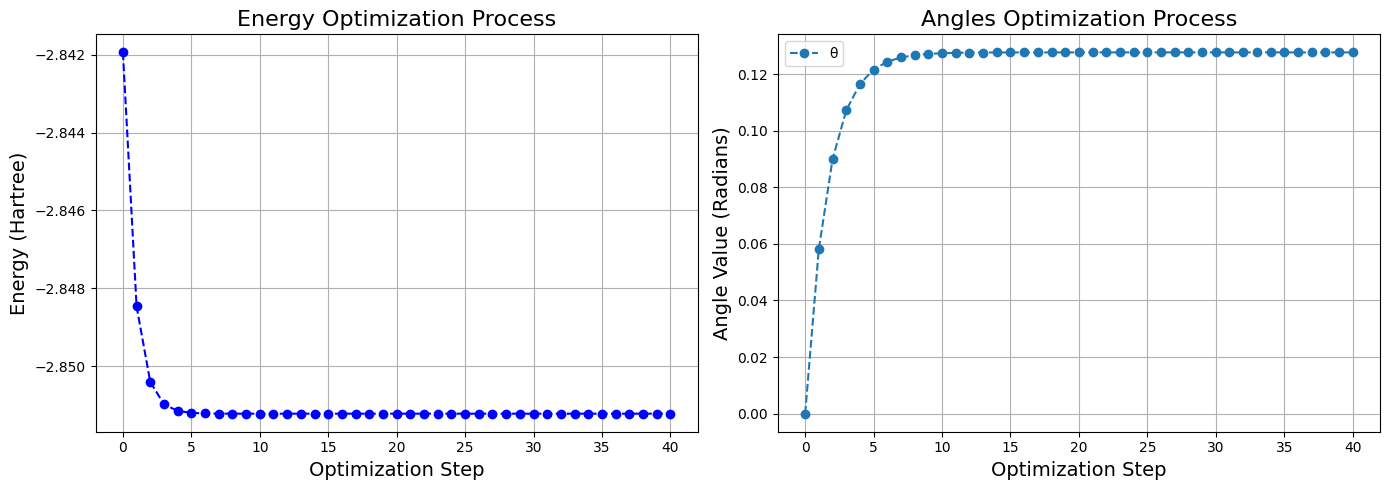

In [ ]:
#@title **Visualisation of the Gradient Descent Optimization Convergence**
# visualizes the convergence of energy and parameter values over optimization steps

angle = np.array(angle)

# Plot energy values vs optimization steps
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)  # First subplot for energy
plt.plot(range(max_iterations + 1), energy, marker='o', linestyle='--', color='b')
plt.title('Energy Optimization Process', fontsize=16)
plt.xlabel('Optimization Step', fontsize=14)
plt.ylabel('Energy (Hartree)', fontsize=14)
plt.grid()

# Plot angles vs optimization steps
plt.subplot(1, 2, 2)  # Second subplot for angles
for i in range(angle.shape[1]):  # Plot each parameter in a separate line
    plt.plot(range(max_iterations + 1), angle[:, i], marker='o', linestyle='--', label=f'θ')


plt.title('Angles Optimization Process', fontsize=16)
plt.xlabel('Optimization Step', fontsize=14)
plt.ylabel('Angle Value (Radians)', fontsize=14)
plt.legend()
plt.grid()

# Show plots
plt.tight_layout()
plt.show()

In [ ]:
#@title **Adam Optimization for Ground State Energy**

import matplotlib.pyplot as plt

opt = qml.AdamOptimizer(stepsize=0.01)
theta = qml.numpy.array([0.0], requires_grad=True) # initial

energy = [cost_function(theta)] # energy array
angle = [theta]
max_iterations = 20

for n in range(max_iterations):
  theta, prev_energy = opt.step_and_cost(cost_function, theta)
  energy.append(cost_function(theta))
  angle.append(theta)

  print(f"Step = {n}, Energy = {energy[-1]:.8f} Ha")

print()
print(f"Final Ground Energy: {energy[-1]:.8f} Ha")
print( f"Final Angle Parameters: {theta[0]:.8f}")

Step = 0, Energy = -2.84333274 Ha
Step = 1, Energy = -2.84461275 Ha
Step = 2, Energy = -2.84577433 Ha
Step = 3, Energy = -2.84681647 Ha
Step = 4, Energy = -2.84773902 Ha
Step = 5, Energy = -2.84854274 Ha
Step = 6, Energy = -2.84922955 Ha
Step = 7, Energy = -2.84980264 Ha
Step = 8, Energy = -2.85026663 Ha
Step = 9, Energy = -2.85062768 Ha
Step = 10, Energy = -2.85089359 Ha
Step = 11, Energy = -2.85107374 Ha
Step = 12, Energy = -2.85117900 Ha
Step = 13, Energy = -2.85122145 Ha
Step = 14, Energy = -2.85121400 Ha
Step = 15, Energy = -2.85116986 Ha
Step = 16, Energy = -2.85110200 Ha
Step = 17, Energy = -2.85102243 Ha
Step = 18, Energy = -2.85094171 Ha
Step = 19, Energy = -2.85086849 Ha

Final Ground Energy: -2.85086849 Ha
Final Angle Parameters: 0.15258178


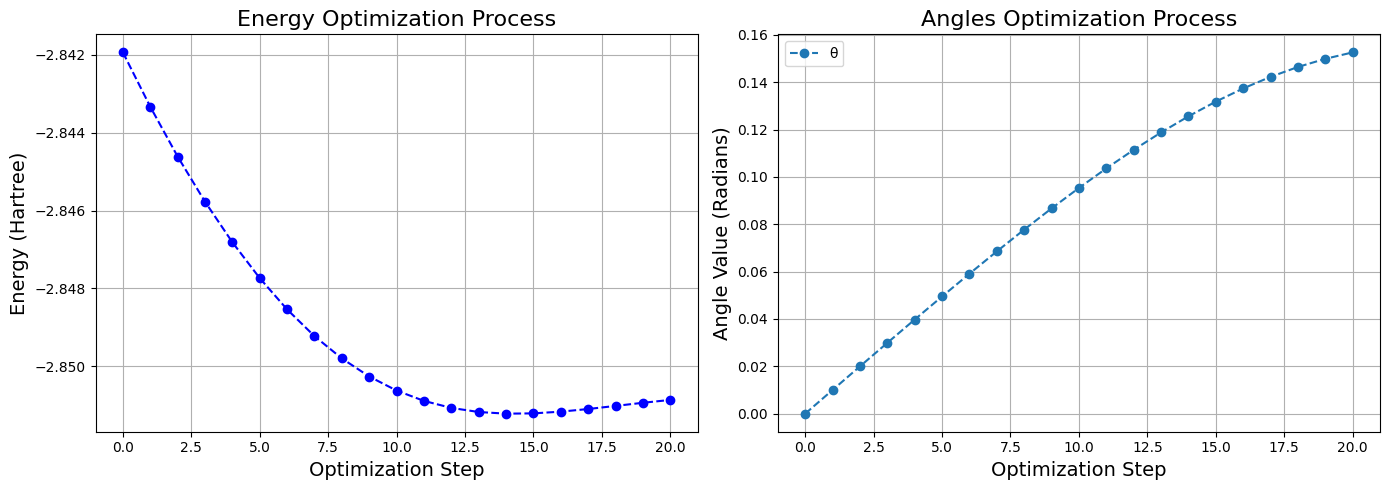

In [ ]:
#@title **Visualisation of the Adam Optimization Convergence**

angle = np.array(angle)

# Plot energy values vs optimization steps
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)  # First subplot for energy
plt.plot(range(max_iterations + 1), energy, marker='o', linestyle='--', color='b')
plt.title('Energy Optimization Process', fontsize=16)
plt.xlabel('Optimization Step', fontsize=14)
plt.ylabel('Energy (Hartree)', fontsize=14)
plt.grid()

# Plot angles vs optimization steps
plt.subplot(1, 2, 2)  # Second subplot for angles
for i in range(angle.shape[1]):  # Plot each parameter in a separate line
    plt.plot(range(max_iterations + 1), angle[:, i], marker='o', linestyle='--', label=f'θ')

plt.title('Angles Optimization Process', fontsize=16)
plt.xlabel('Optimization Step', fontsize=14)
plt.ylabel('Angle Value (Radians)', fontsize=14)
plt.legend()
plt.grid()

# Show plots
plt.tight_layout()
plt.show()

In [ ]:
#@title **SPSA for Ground State Energy**

import matplotlib.pyplot as plt
import pennylane as qml
import numpy as np

# Energy tracking
energy = [cost_function(theta)]
angle = [theta]
max_iterations = 20

# Define optimizer and initialization
opt = qml.SPSAOptimizer(maxiter=max_iterations)
theta = qml.numpy.array([0.0], requires_grad=True)  # initial angle

for n in range(max_iterations):
    theta, prev_energy = opt.step_and_cost(cost_function, theta)
    curr_energy = cost_function(theta)

    energy.append(curr_energy)
    angle.append(theta)

    print(f"Step = {n}, Energy = {curr_energy:.8f} Ha")

print()
print(f"Final Ground Energy: {energy[-1]:.8f} Ha")
print(f"Final Angle Parameters: {theta[0]:.8f}")

Step = 0, Energy = -2.84295565 Ha
Step = 1, Energy = -2.84372354 Ha
Step = 2, Energy = -2.84433489 Ha
Step = 3, Energy = -2.84483942 Ha
Step = 4, Energy = -2.84526647 Ha
Step = 5, Energy = -2.84563479 Ha
Step = 6, Energy = -2.84595714 Ha
Step = 7, Energy = -2.84624256 Ha
Step = 8, Energy = -2.84649771 Ha
Step = 9, Energy = -2.84672764 Ha
Step = 10, Energy = -2.84693625 Ha
Step = 11, Energy = -2.84712663 Ha
Step = 12, Energy = -2.84730126 Ha
Step = 13, Energy = -2.84746217 Ha
Step = 14, Energy = -2.84761102 Ha
Step = 15, Energy = -2.84774920 Ha
Step = 16, Energy = -2.84787790 Ha
Step = 17, Energy = -2.84799811 Ha
Step = 18, Energy = -2.84811069 Ha
Step = 19, Energy = -2.84821637 Ha

Final Ground Energy: -2.84821637 Ha
Final Angle Parameters: 0.05503781


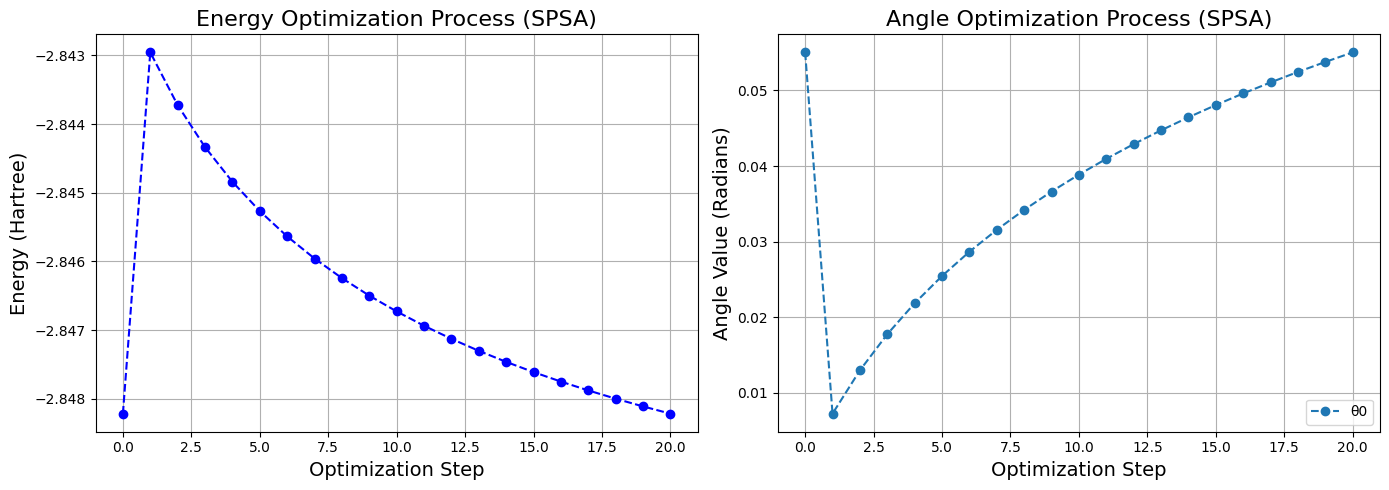

In [ ]:
#@title **Visualisation of the SPSA Convergence**

angle = np.array(angle)

# Plot energy values vs optimization steps
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(range(max_iterations + 1), energy, marker='o', linestyle='--', color='b')
plt.title('Energy Optimization Process (SPSA)', fontsize=16)
plt.xlabel('Optimization Step', fontsize=14)
plt.ylabel('Energy (Hartree)', fontsize=14)
plt.grid()

# Plot angles vs optimization steps
plt.subplot(1, 2, 2)
for i in range(angle.shape[1]):
    plt.plot(range(max_iterations + 1), angle[:, i], marker='o', linestyle='--', label=f'θ{i}')

plt.title('Angle Optimization Process (SPSA)', fontsize=16)
plt.xlabel('Optimization Step', fontsize=14)
plt.ylabel('Angle Value (Radians)', fontsize=14)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()